# Лабораторная работа №1
## $P | prec, p_i=1 | C_{max}$

**Задача**: найти расписание с минимальным временем окончания всех работ
на **$m$** параллельных машинах с длительностями работ $p_i=1$ и условиями
предшествования, то есть предполагается известным ориентированный граф
без циклов, вершинами которого являются работы, а дуги задают частичный
порядок выполнения работ.

Реализовать алгоритм решения с помощью библиотеки Pyomo и собственный жадный алгоритм для решения данной задачи, создать универсальный формат задания задачи.

In [76]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import networkx as nx
from functools import reduce
import pandas as pd
import shutil
import sys
import json
import os.path
from pyomo.environ import *
from pyomo.gdp import *
import time 
from pyomo.contrib.latex_printer import latex_printer
import importlib
import script

In [77]:
# Запись задачи в JSON формат
def WriteJson(dictionary: dict, name = "task.json"):
    with open(name, 'w') as f:
        json.dump(dictionary, f)

# Чтение задачи из JSON формата
def ReadJson(name = "task.json") -> dict:
    with open(name, 'r') as f:
        m = json.loads(f.read())
        return m

In [78]:
# Отрисовка диаграммы Ганта
def Gantt(JOBS, SCHEDULE={}, ax1=None, ax2=None):
    bw = 0.3
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax1.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax1.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    ax1.set_ylim(-0.5, idx-0.5)
    ax1.set_title('Job Schedule')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Jobs')
    ax1.set_yticks(range(len(JOBS)), JOBS.keys())
    ax1.grid()
    xlim = ax1.get_xlim()

    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax2.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax2.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax2.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        ax2.set_xlim(xlim)
        ax2.set_ylim(-0.5, len(MACHINES)-0.5)
        ax2.set_title('Machine Schedule')
        ax2.set_yticks(range(len(MACHINES)), MACHINES)
        ax2.set_ylabel('Machines')
        ax2.grid()

# Подсчет метрик для решенной задачи
def Kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

## Реализация в Pyomo

In [79]:
#Создание метода решения через Pyomo
def ScheduleMachines(JOBS, MACHINES):
    from pyomo.environ import ConcreteModel, Set, Var, NonNegativeReals, Binary, Constraint, Objective, SolverFactory, minimize

    # Создание модели pyomo
    m = ConcreteModel()

    # инициализация основных списков модели.
    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    # инициализация переменных модели с ограничениями на значения (от 0 до 1000) или NonNegativeReals
    m.start      = Var(m.J, bounds=(0, 1000))
    m.makespan   = Var(domain=NonNegativeReals)

    #разницы между реальным окончанием работы и директивным
    m.pastdue    = Var(m.J, domain=NonNegativeReals)
    m.early      = Var(m.J, domain=NonNegativeReals)

    # переменные модели которые будут использоваться в ограничениях
    m.ispastdue  = Var(m.J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)

    # матрица бинарного соответствия работ машинам
    m.z = Var(m.J, m.M, domain=Binary)

    # for modeling disjunctive constraints
    m.y = Var(m.PAIRS, domain=Binary)

    BigM = max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J])

    #задание функции которую необходимо минимизировать. В данном случае - время окончание всех работ.
    m.OBJ = Objective(expr = m.makespan, sense = minimize)


    m.c1 = Constraint(m.J, rule=lambda m, j:
            m.start[j] >= JOBS[j]['release'])

    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])

    #задание условия, что одна работа не может выполняться на нескольких машинах. Внимание стоит обратить на синтаксис без if
    m.c3 = Constraint(m.J, rule=lambda m, j:
            sum(m.z[j,mach] for mach in m.M) == 1)

    m.c4 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= BigM*m.ispastdue[j])

    m.c5 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= m.maxpastdue)


    m.c6 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] <= m.makespan)

    m.d1 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[j] + JOBS[j]['duration'] <= m.start[k] + BigM*(m.y[j,k] + (1-m.z[j,mach]) + (1-m.z[k,mach])))

    m.d2 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[k] + JOBS[k]['duration'] <= m.start[j] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))


    #в следующием коде задаётся граф выполнения работ
    i = 1
    for job in JOBS:
        for dependency in JOBS[job]["dependencies"]:
            setattr(m, f"c_{6 + i}", Constraint(expr = m.start[dependency] >= (m.start[job] + JOBS[job]['duration'])))
            i += 1

    #метод решения glpk
    result = SolverFactory('glpk',executable=r"C:\glpk\glpk-4.65\w32\glpsol.exe").solve(m)

    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {
            'start': m.start[j](),
            'finish': m.start[j]() + JOBS[j]['duration'],
            'machine': [mach for mach in MACHINES if m.z[j,mach]()][0]
        }

    return SCHEDULE, m

## Жадный алгоритм $O(n^2)$

In [80]:
# Нахождение задач, которые не зависят от других в данный момент
# Задачи сортируются по количеству зависящих от них других задач
def Roots(graph: dict):
    roots = list(set(graph.keys()) - set(reduce(lambda x, y: x + y , graph.values(), [])))
    sorted(roots, key=lambda x: -len(graph[x]))
    return roots

# Распределение m первых задач по машинам
def Cut(graph: dict, roots: list, topn: int):
    assert(topn > 0)
    result = graph.copy()
    cutted = []
    
    for i in roots:
        result.pop(i)
        cutted.append(i)
        topn -= 1
        
        if topn == 0:
            break
    
    return result, cutted

# Формирование ответа
def Sheduler(answer: list, jobs: dict, machines: list):
    result = {}
    start_time = jobs[next(iter(jobs))]["release"]
    duration = jobs[next(iter(jobs))]["duration"]
    
    for i, bucket in enumerate(answer):
        for j, job in enumerate(bucket):
            result[job] = {
                'start': float(start_time + i * duration),
                'finish': float(start_time + (i + 1) * duration),
                'machine': machines[j],
            }
    
    return result

# Жадный алгоритм
def Solve(jobs: dict, machines: list, verbose = False):
    graph = {i: jobs[i]["dependencies"] for i in jobs}

    layout = nx.spring_layout(ToNXGraph(graph))
    
    answer = []
    while graph: # Пока есть необработанные задачи
        prev_graph = ToNXGraph(graph)
        
        roots = Roots(graph)
        graph, cutted = Cut(graph, roots, len(machines))
        
        new_graph = ToNXGraph(graph)
        
        if not verbose:
            color_map = ['red' if node in roots[:len(machines)] else '#1f78b4' for node in prev_graph]
            fig, ax = plt.subplots(1, 2, figsize=(15,5))
            
            nx.draw_networkx(prev_graph, pos=layout, ax=ax[0], node_color=color_map)
            nx.draw_networkx(new_graph, pos=layout, ax=ax[1])

        answer.append(cutted)
    
    return Sheduler(answer, jobs, machines)

---

In [81]:
def ToNXGraph(graph):
    g = nx.DiGraph()
    for i in graph:
        g.add_node(i)
        for j in graph[i]:
            g.add_edge(i, j)
    
    return g

def Test(name, verbose = False):
    DATA = ReadJson(name=name)

    #Задание спика машин
    MACHINES = DATA["MACHINES"]

    #Задание словаря работ
    JOBS = DATA["JOBS"]

    g = ToNXGraph({i: JOBS[i]["dependencies"] for i in JOBS})

    SCHEDULE2 = Solve(JOBS, MACHINES, verbose)
    SCHEDULE1, MODEL = ScheduleMachines(JOBS, MACHINES)
    
    if not verbose:
        fig, ax = plt.subplots(3, 2, figsize=(15,14))
        fig.suptitle(f"{name}")
        ax[0][0].get_xaxis().set_visible(False)
        ax[0][0].get_yaxis().set_visible(False)
        ax[0][0].set_axis_off()
        ax[0][0].text(0.5, 0.5, f"Best: {Kpi(JOBS, SCHEDULE1)['Makespan']}\n"
                     f"Greedy: {Kpi(JOBS, SCHEDULE2)['Makespan']}")

        nx.draw_networkx(g, ax=ax[0][1])
        Gantt(JOBS, SCHEDULE1, ax[1][0], ax[2][0]) 
        Gantt(JOBS, SCHEDULE2, ax[1][1], ax[2][1])

    return Kpi(JOBS, SCHEDULE1)['Makespan'], Kpi(JOBS, SCHEDULE2)['Makespan'], len(g.edges())

In [82]:
df = pd.DataFrame(columns=["Edge Count", "Score", "Greedy score", "Delta"])
for m in range(20): # 20 тестов
    WriteJson(script.create_task(3, 10, 1, 1, 12, m=m+13))
    v1, v2, edge_count = Test("task.json", verbose = True)
    df.loc[m] = [edge_count, v1, v2, abs(v2-v1) if v1 is not None else None]
    print(f"[{m}] Task solved.")

[0] Task solved.
[1] Task solved.
[2] Task solved.
[3] Task solved.
[4] Task solved.
[5] Task solved.
[6] Task solved.
[7] Task solved.
[8] Task solved.
[9] Task solved.
[10] Task solved.
[11] Task solved.
[12] Task solved.
[13] Task solved.
[14] Task solved.
[15] Task solved.
[16] Task solved.
[17] Task solved.
[18] Task solved.
[19] Task solved.


In [83]:
df

,Edge Count,Score,Greedy score,Delta
0,13.0,6.0,6.0,0.0
1,14.0,8.0,8.0,0.0
2,15.0,8.0,8.0,0.0
3,16.0,5.0,6.0,1.0
4,17.0,9.0,9.0,0.0
5,18.0,8.0,8.0,0.0
6,19.0,9.0,9.0,0.0
7,20.0,9.0,9.0,0.0
8,21.0,11.0,11.0,0.0
9,22.0,8.0,8.0,0.0


### Пример:

(5.0, 6.0, 10)

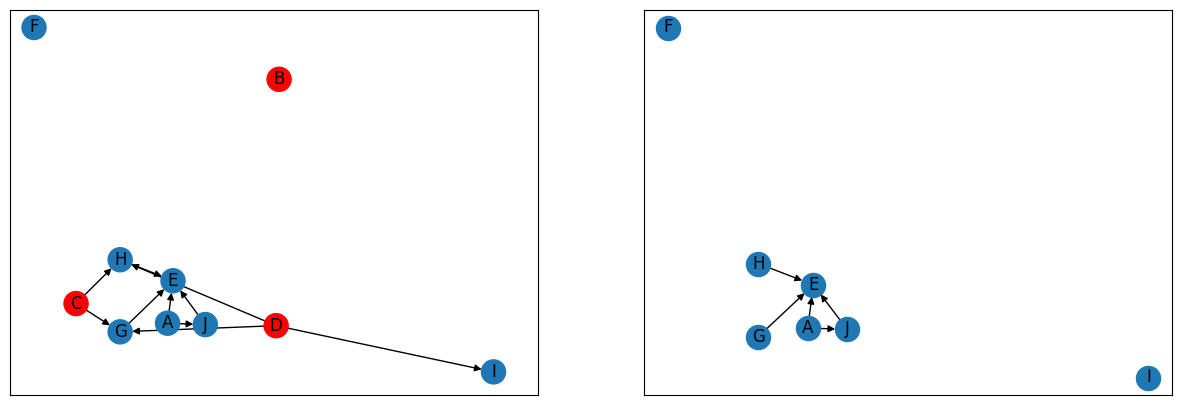

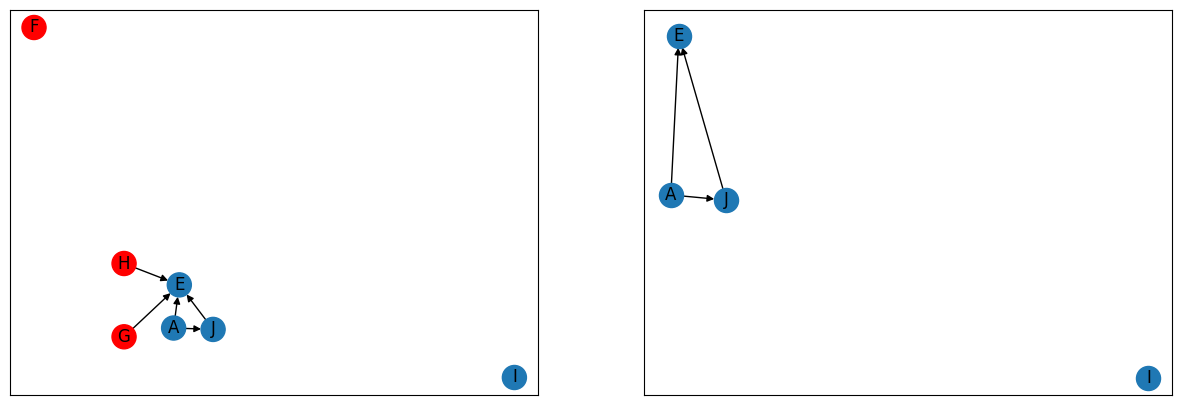

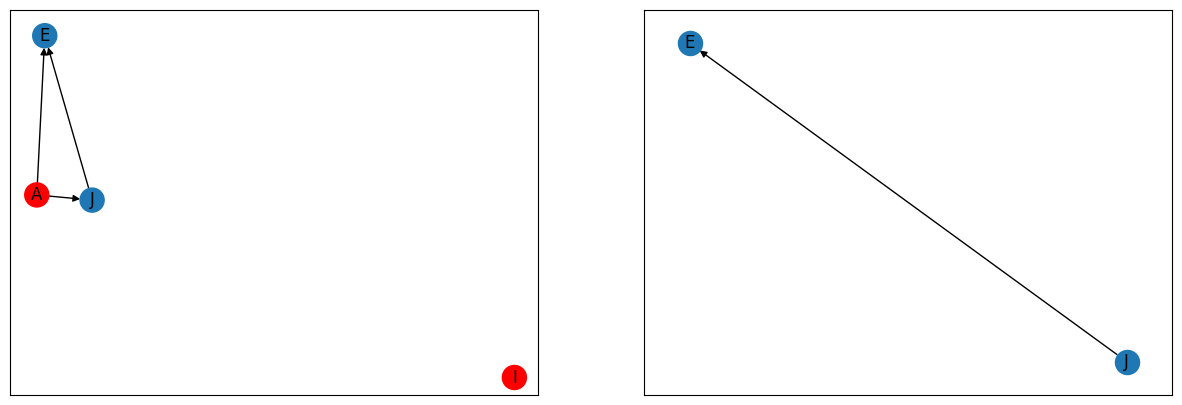

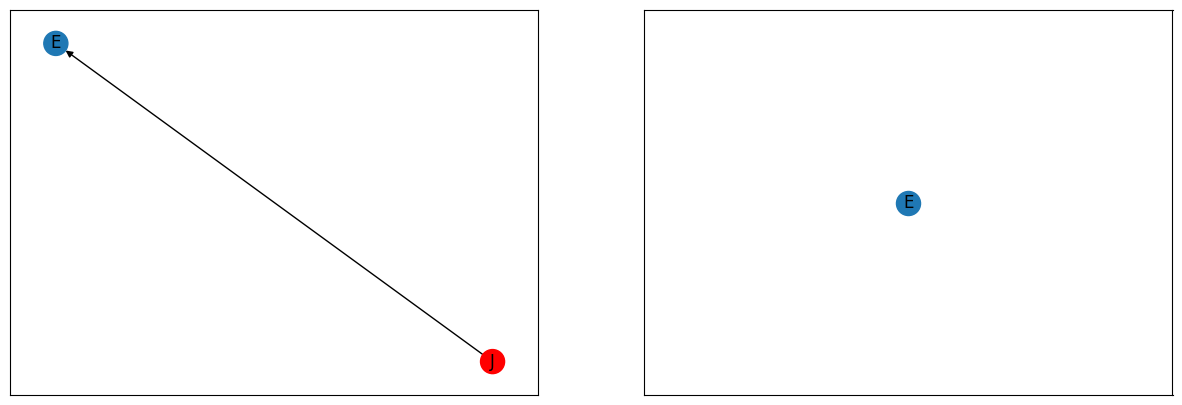

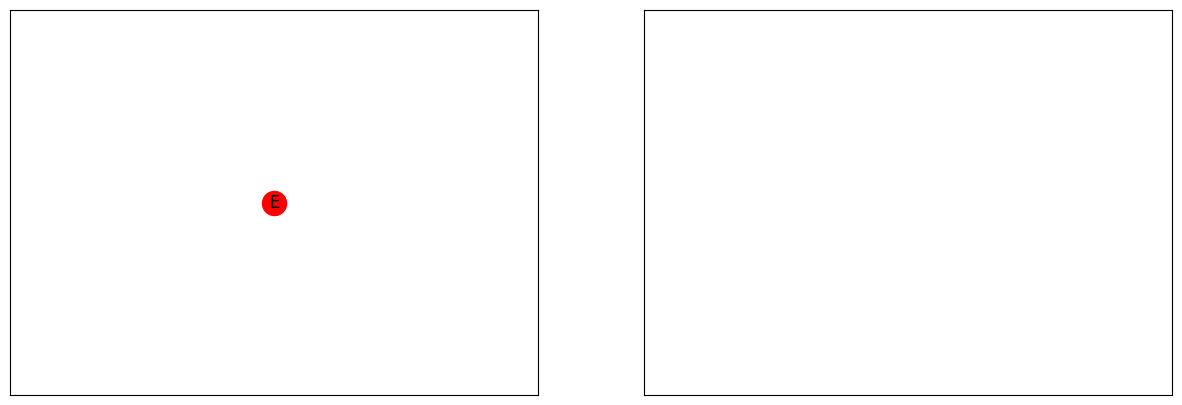

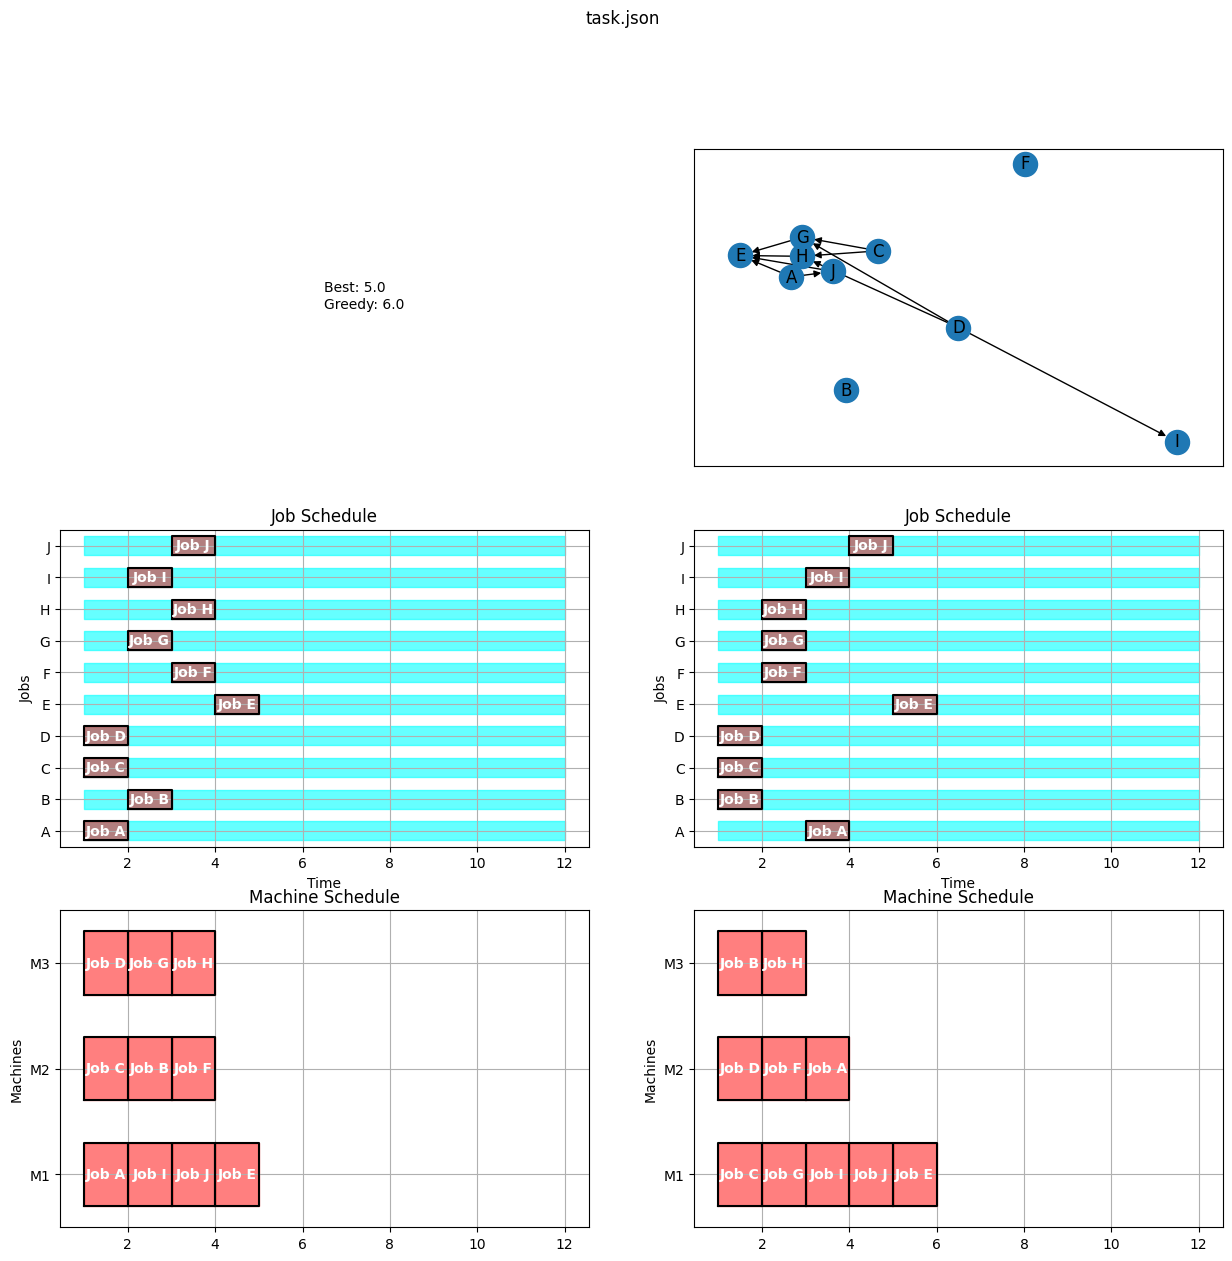

In [84]:
WriteJson(script.create_task(3, 10, 1, 1, 12, m=10))
Test("task.json")

## Вывод

В ходе лабораторной работы я решил $P | prec, p_i=1 | C_{max}$ проблему с помощью фреймворка Pyomo, предоставляющего интерфейс для постановки задач линейного программирования и передачей их решателям. А также разработал собственный жадный алгоритм на основе графового представления задачи. На практике собственный алгоритм оказывается сильно быстрее, при этом практически никогда не ухудшая результат по сравнению с точным решением.